In [1]:
import sys
external_pkgs_paths = [r".\external_pkgs\gym-0.18.3\gym-0.18.3"]
for path in external_pkgs_paths:
    if path not in sys.path:
        sys.path.insert(0, path) 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# # the installed packages won't be present next time you open the notebook in colab...
# !pip install sympy
# # Install only once. Tomorrow, you can skip this.  But this may cause multiple compatibility issues...
# !pip install --target=external_pkgs ta
# !pip install pyyaml

In [ ]:

# !pip install sympy
# !pip install pyyaml
# !pip install tqdm

In [2]:
# import necessary modules
import ta
from functools import reduce
import pandas as pd
import gc
import pickle
import tensortrade as td
from tensortrade.data.external import *

from tensortrade.exchanges import Exchange
from tensortrade.instruments import Instrument, CNY, USD
from tensortrade.wallets import Wallet, Portfolio
from tensortrade.exchanges.services.execution.simulated import execute_order
from tensortrade.data import Stream, Module, DataFeed

In [4]:
# user-defined data
train_time_interval = ['20170101', '20181231']
test_time_interval = ['20190101', '20201231']
dpx_file_path = r'F:\MarketData\Stock\stock_dpx_20140110-20210115'

# In[ load data]:
all_stocks = pd.read_csv(dpx_file_path + '\\20171103.dpx.csv',
                         converters={'#TICKER': lambda x: str(x), 'DATE_': lambda x: str(x)},
                         encoding='ISO-8859-1')
stock_names = all_stocks['NAME']
stock_tickers = all_stocks['#TICKER']

ticker = '000002'
train_data = getSingleStockData(ticker, train_time_interval, dpx_file_path)
test_data = getSingleStockData(ticker, test_time_interval, dpx_file_path)
# train_data.to_csv("train_data.csv")
# test_data.to_csv("test_data.csv")
# train_data = pd.read_csv("train_data.csv", index_col=0)
# test_data = pd.read_csv("test_data.csv", index_col=0)

In [5]:
train_data

,OPEN,HIGH,LOW,CLOSE,VOLUME
DATE_,,,,,
20170103,20.55,20.88,20.55,20.73,21701669.0
20170104,20.74,20.95,20.45,20.85,33155480.0
20170105,20.85,21.23,20.78,20.93,31012563.0
20170106,20.94,21.04,20.61,20.64,23591954.0
20170109,20.60,20.75,20.53,20.66,15095445.0
...,...,...,...,...,...
20181224,23.92,24.08,23.33,23.88,49321942.0
20181225,23.42,24.22,23.38,23.97,42690126.0
20181226,23.84,23.98,23.58,23.80,22198726.0


In [7]:
N000001 = Instrument('平安银行', 2, '000001')
N000002 = Instrument('万科A', 2, '000002')
config = {
    "base_instrument": CNY,
    "instruments": [N000002]
}

with td.TradingContext(**config):
    exchange_name = 'train_data_exchange'
    train_data_exchange = Exchange(exchange_name, service=execute_order)(
        Stream("-".join([N000002.symbol, CNY.symbol]), list(train_data['CLOSE']))
        # internal feed need the quote symbol presented in the front of the name of the price Stream --- > need to improve this
    )
train_data_exchange.build()
print(train_data_exchange._prices)

with td.TradingContext(**config):
    exchange_name = 'test_data_exchange'
    test_data_exchange = Exchange(exchange_name, service=execute_order)(
        Stream("-".join([N000002.symbol, CNY.symbol]), list(test_data['CLOSE']))
    )
test_data_exchange.build()
print(test_data_exchange._prices)

{'万科A/CNY': <Node: name=万科A-CNY, type=forward>}
{'万科A/CNY': <Node: name=万科A-CNY, type=forward>}


In [8]:
# In[build data feed]:
from tensortrade.data import DataFeed, Module

raw_col_map = {'open': 'OPEN',
               'high': 'HIGH',
               'low': 'LOW',
               'close': 'CLOSE',
               'volume': 'VOLUME'}

colprefix = "万科A"
module_name = "general_ta_features"

feature_list = None  # ["volume_cmf","trend_macd_diff", "momentum_rsi", "trend_cci", "momentum_tsi", "momentum_kama", "volatility_kch"]


def create_ta_features_feed(raw_data, raw_col_map, colprefix, module_name, drop_raw=True, feature_list=None):
    feature_data = raw_data.copy(deep=True)
    colprefix = colprefix + "_"

    num_raw_cols = feature_data.shape[1]

    ta.add_all_ta_features(feature_data,
                           colprefix=colprefix,
                           **raw_col_map)

    if drop_raw:
        feature_data = feature_data.iloc[:, num_raw_cols:]

    if feature_list is None:
        feature_list = feature_data.columns.tolist()
    else:
        feature_list = [colprefix + x for x in feature_list]

    with Module(module_name) as ns:
        for col in feature_list:
            ns = ns(Stream(col, list(feature_data[col])))
    feed = DataFeed([ns])
    return feed


train_feed = create_ta_features_feed(raw_data=train_data,
                                     raw_col_map=raw_col_map,
                                     colprefix=colprefix,
                                     module_name=module_name,
                                     feature_list=feature_list)

test_feed = create_ta_features_feed(raw_data=test_data,
                                    raw_col_map=raw_col_map,
                                    colprefix=colprefix,
                                    module_name=module_name,
                                    feature_list=feature_list)

e:\fintech_capstone\venv\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
e:\fintech_capstone\venv\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
e:\fintech_capstone\venv\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
e:\fintech_capstone\venv\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [15]:
train_feed.next()

{'general_ta_features:/万科A_volume_adi': -27573515.195871226,
 'general_ta_features:/万科A_volume_obv': 44590835.0,
 'general_ta_features:/万科A_volume_cmf': nan,
 'general_ta_features:/万科A_volume_fi': nan,
 'general_ta_features:/万科A_volume_em': -0.12273780004055929,
 'general_ta_features:/万科A_volume_sma_em': nan,
 'general_ta_features:/万科A_volume_vpt': -209143.86142431095,
 'general_ta_features:/万科A_volume_vwap': nan,
 'general_ta_features:/万科A_volume_mfi': nan,
 'general_ta_features:/万科A_volume_nvi': 990.8872901678657,
 'general_ta_features:/万科A_volatility_bbm': nan,
 'general_ta_features:/万科A_volatility_bbh': nan,
 'general_ta_features:/万科A_volatility_bbl': nan,
 'general_ta_features:/万科A_volatility_bbw': nan,
 'general_ta_features:/万科A_volatility_bbp': nan,
 'general_ta_features:/万科A_volatility_bbhi': 0.0,
 'general_ta_features:/万科A_volatility_bbli': 0.0,
 'general_ta_features:/万科A_volatility_kcc': nan,
 'general_ta_features:/万科A_volatility_kch': 21.037619047619046,
 'general_ta_feature

In [28]:
len(train_feed.next())

86

In [17]:
# In[create portfolio(s)]:

with td.TradingContext(**config):
    train_portfolio = Portfolio(CNY, [
        Wallet(train_data_exchange, 100000 * CNY),
        Wallet(train_data_exchange, 100 * N000002)
    ])

with td.TradingContext(**config):
    test_portfolio = Portfolio(CNY, [
        Wallet(test_data_exchange, 100000 * CNY),
        Wallet(test_data_exchange, 100 * N000002)
    ])

In [19]:
import numpy as np
np.arange(0, 0.91, 0.1).tolist()

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9]

In [29]:
# In[deploy action schemes]:
from MoneyPositionScheme import *

# In[deploy reward schemes]:
from RelativeReturnReward import RelativeReturnReward

# In[create environment]:
from tensortrade.environments import TradingEnvironment

train_Action = DiscretePositionScheme(positionList=np.arange(0, 0.91, 0.1).tolist())
test_Action = DiscretePositionScheme(positionList=np.arange(0, 0.91, 0.1).tolist())
relativeReward = RelativeReturnReward()
window_size = 40
max_episode_timesteps = 60
stochastic_reset = True
with td.TradingContext(**config):
    train_env = TradingEnvironment(portfolio=train_portfolio,
                                   # action_scheme='managed-risk',
                                   # reward_scheme='simple',
                                   reward_scheme=relativeReward,
                                   action_scheme=train_Action,
                                   max_episode_timesteps=max_episode_timesteps,
                                   external_feed=train_feed,
                                   window_size=window_size,
                                   observe_internal_feed=False,
                                   on_execute_verbose=False,
                                   stochastic_reset=stochastic_reset)

    test_env = TradingEnvironment(portfolio=test_portfolio,
                                  # action_scheme='managed-risk',
                                  # reward_scheme='simple',
                                  reward_scheme=relativeReward,
                                  action_scheme=test_Action,
                                  max_episode_timesteps=max_episode_timesteps,
                                  external_feed=test_feed,
                                  window_size=window_size,
                                  observe_internal_feed=False,
                                  on_execute_verbose=False,
                                  stochastic_reset=stochastic_reset)

# env.reset() 

In [10]:
# ! pip install tensorflow
# !pip install tqdm

In [21]:
import tensorflow as tf


In [30]:
# In[deploy network api]:
import tensorflow as tf

# In[config network structure]:

# tf.reset_default_graph()
with tf.device(
        '/CPU:0'):  # tf2.3.will raise error if there are other tf GPU processes running on this device(maybe Chrome)
    network = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=train_env.observation_space.shape),
        tf.keras.layers.Conv1D(filters=5, kernel_size=5, padding="valid", activation="tanh"),  # horizontal filter
        # tf.keras.layers.MaxPooling1D(pool_size=3),
        tf.keras.layers.Conv1D(filters=4, kernel_size=5, padding="valid", activation="tanh"),
        # tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(128, activation="relu"),
        # tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(len(train_env.action_space), activation="relu")
    ])


In [27]:
train_env.observation_space.shape

(40, 86)

In [26]:
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 5)             2155      
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 4)             104       
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 11)                1419      
                                                                 
Total params: 3,678
Trainable params: 3,678
Non-trainable params: 0
_________________________________________________________________


In [31]:
from tensortrade.agents import DQNAgent

agent_spec = {
    'discount_factor': 0.5,
    'learning_rate': 0.0001,
    'batch_size': 256,
    'eps_start': 1,
    'eps_end': 0.1,
    'eps_decay_steps': 20,
    'update_target_every': 20,
    'memory_capacity': 10000,
    "ini_steps": 512,
    "max_episode_timesteps": train_env.max_episode_timesteps}
save_path = None  # r'.\models\train'
step_verbose = False
episode_verbose = False
n_episodes = 10
save_every = 100
evaluate_every_n_episode = 2
save_episodic_performance = False

<AxesSubplot:xlabel='DATE_'>

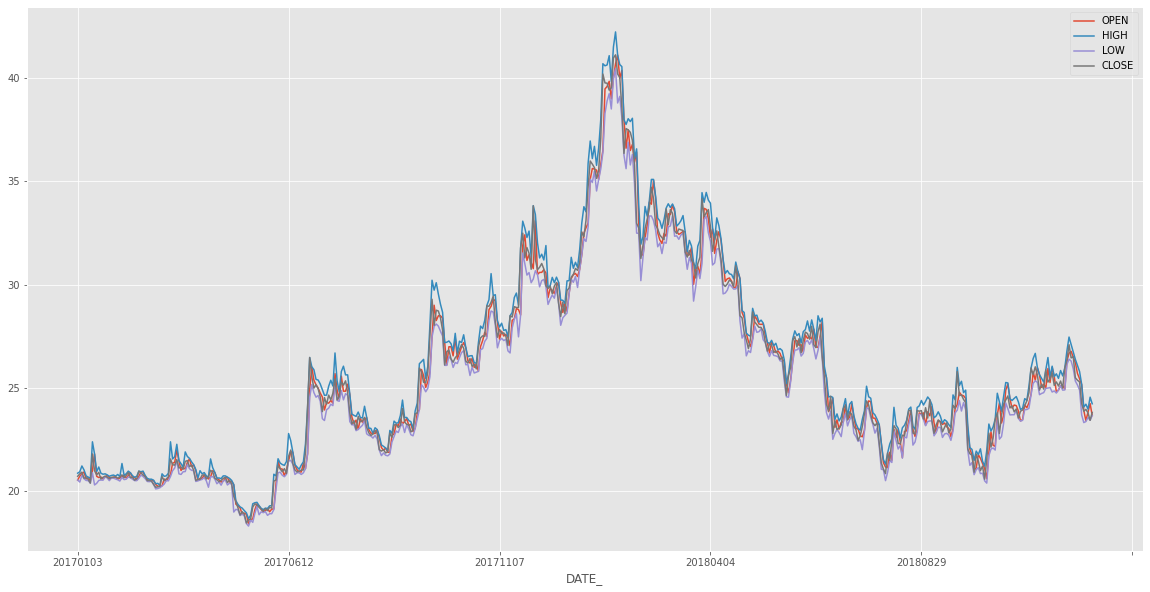

In [32]:
train_data.plot(figsize=(20,10), y = ["OPEN", "HIGH", "LOW", "CLOSE"])

In [24]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [01:37<00:00,  5.23it/s]


Start training...


 10%|███████████                                                                                                   | 1/10 [00:10<01:30, 10.09s/it]

Evaluation after 2 episodes (442 steps) with average reward: -31.657974527439958


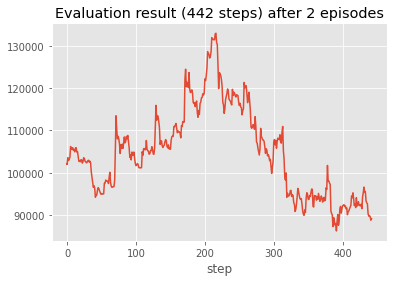

 30%|█████████████████████████████████                                                                             | 3/10 [00:34<01:11, 10.24s/it]

Evaluation after 4 episodes (442 steps) with average reward: -0.17833038442588456


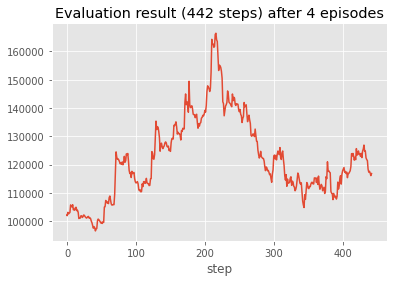

 50%|███████████████████████████████████████████████████████                                                       | 5/10 [01:05<01:04, 12.84s/it]

Evaluation after 6 episodes (442 steps) with average reward: 0.0013423920416567676


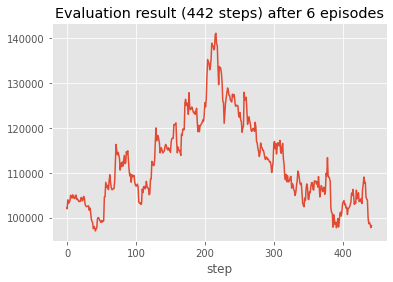

 70%|█████████████████████████████████████████████████████████████████████████████                                 | 7/10 [01:45<00:47, 15.85s/it]

Evaluation after 8 episodes (442 steps) with average reward: -31.423018376011395


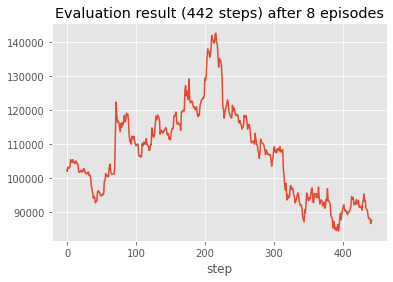

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [02:23<00:16, 16.90s/it]

Evaluation after 10 episodes (442 steps) with average reward: -27.8125913762078


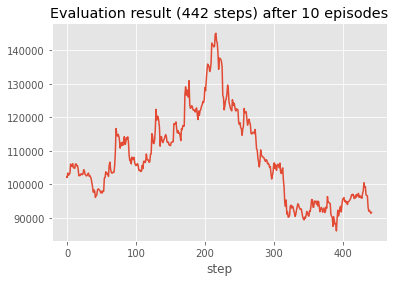

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:44<00:00, 16.44s/it]


In [33]:
with tf.device('/CPU:0'):
    myAgent = DQNAgent(train_env, policy_network=network)
    myAgent.train(n_episodes=n_episodes,
                  save_every=save_every,
                  save_path=save_path,
                  step_verbose=step_verbose,
                  episode_verbose=episode_verbose,
                  evaluate_every_n_episode=evaluate_every_n_episode,
                  save_episodic_performance=save_episodic_performance,
                  **agent_spec)

In [34]:
train_data

,OPEN,HIGH,LOW,CLOSE,VOLUME
DATE_,,,,,
20170103,20.55,20.88,20.55,20.73,21701669.0
20170104,20.74,20.95,20.45,20.85,33155480.0
20170105,20.85,21.23,20.78,20.93,31012563.0
20170106,20.94,21.04,20.61,20.64,23591954.0
20170109,20.60,20.75,20.53,20.66,15095445.0
...,...,...,...,...,...
20181224,23.92,24.08,23.33,23.88,49321942.0
20181225,23.42,24.22,23.38,23.97,42690126.0
20181226,23.84,23.98,23.58,23.80,22198726.0


In [35]:
myAgent.env = test_env
myAgent.test(start_step = 40,
             n_steps=100)

TypeError: 'int' object is not subscriptable

In [15]:
myAgent.get_action(train_env.reset())

array([0], dtype=int64)